## 6 Optimiser 2

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import PIL
from torchsummary import summary

In [ ]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 40
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])


test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 16, 16])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 6, 3, 7, 9, 4, 8, 3, 7, 7])


In [ ]:
class CNN2Adam(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(64*2*2, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model2_adam = CNN2Adam(num_classes=10)

In [ ]:
model2_adam = model2_adam.to(DEVICE)

In [ ]:
print(summary(model2_adam, (3, 16, 16)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           2,080
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 4, 4]           8,256
              ReLU-8             [-1, 64, 4, 4]               0
         MaxPool2d-9             [-1, 64, 2, 2]               0
           Linear-10                  [-1, 100]          25,700
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 37,494
Trainable params: 37,494
Non-trainable params: 0
---------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


In [ ]:
optimizer_adam = torch.optim.Adam(model2_adam.parameters())
scheduler_adam = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_adam, train_acc_list_adam, valid_acc_list_adam = train_model(
    model=model2_adam,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer_adam,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3057
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.7662
Epoch: 001/040 | Train: 38.27% | Validation: 38.68%
Time elapsed: 1.17 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.7116
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.5591
Epoch: 002/040 | Train: 43.92% | Validation: 42.92%
Time elapsed: 2.23 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.4947
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.4455
Epoch: 003/040 | Train: 45.48% | Validation: 45.42%
Time elapsed: 3.28 min
Epoch: 004/040 | Batch 0000/0175 | Loss: 1.6156
Epoch: 004/040 | Batch 0100/0175 | Loss: 1.4471
Epoch: 004/040 | Train: 48.64% | Validation: 48.46%
Time elapsed: 4.30 min
Epoch: 005/040 | Batch 0000/0175 | Loss: 1.4368
Epoch: 005/040 | Batch 0100/0175 | Loss: 1.3712
Epoch: 005/040 | Train: 50.56% | Validation: 50.04%
Time elapsed: 5.35 min
Epoch: 006/040 | Batch 0000/0175 | Loss: 1.2850
Epoch: 006/040 | Batch 0100/0175 | Loss: 1.3460
Epoch: 006/040 | Train: 52.93% | Validation: 52.4

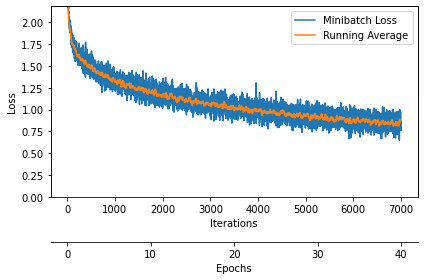

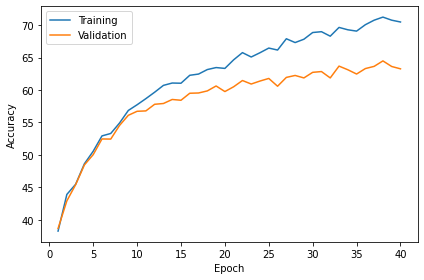

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_adam,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_adam,
              valid_acc_list=valid_acc_list_adam,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()

In [ ]:
class CNN1Adam(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            # torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
            #                 # , padding=2),
            # torch.nn.ReLU(inplace=True),
            # torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(32*4*4, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model1_adam = CNN1Adam(num_classes=10)

In [ ]:
model1_adam = model1_adam.to(DEVICE)

In [ ]:
print(summary(model1_adam, (3, 16, 16)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           2,080
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                  [-1, 100]          51,300
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
Total params: 54,838
Trainable params: 54,838
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.21
Estimated Total Size (MB): 0.32
---------------------------------------------

In [ ]:
optimizer_adam1 = torch.optim.Adam(model1_adam.parameters())
scheduler_adam1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam1,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_adam1, train_acc_list_adam1, valid_acc_list_adam1 = train_model(
    model=model1_adam,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer_adam1,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3071
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.8140
Epoch: 001/040 | Train: 43.08% | Validation: 42.50%
Time elapsed: 1.10 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.6634
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.4919
Epoch: 002/040 | Train: 48.01% | Validation: 47.52%
Time elapsed: 2.13 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.3877
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.4196
Epoch: 003/040 | Train: 51.08% | Validation: 50.42%
Time elapsed: 3.15 min
Epoch: 004/040 | Batch 0000/0175 | Loss: 1.3312
Epoch: 004/040 | Batch 0100/0175 | Loss: 1.2360
Epoch: 004/040 | Train: 53.14% | Validation: 52.40%
Time elapsed: 4.15 min
Epoch: 005/040 | Batch 0000/0175 | Loss: 1.1951
Epoch: 005/040 | Batch 0100/0175 | Loss: 1.2653
Epoch: 005/040 | Train: 54.17% | Validation: 53.10%
Time elapsed: 5.16 min
Epoch: 006/040 | Batch 0000/0175 | Loss: 1.2904
Epoch: 006/040 | Batch 0100/0175 | Loss: 1.2328
Epoch: 006/040 | Train: 55.50% | Validation: 54.6

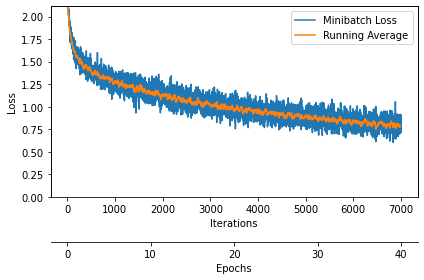

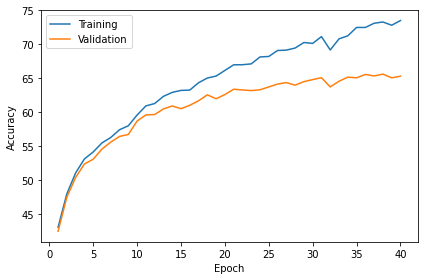

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_adam1,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_adam1,
              valid_acc_list=valid_acc_list_adam1,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()

In [ ]:
import pandas as pd

In [ ]:
results = pd.DataFrame({"Number of Parameters": [54838, 37494], "Accuracy": [74, 71]}, index = ["CNN1", "CNN2"])

In [ ]:
results

,Number of Parameters,Accuracy
CNN1,54838,74
CNN2,37494,71


## Adam was very good with training accuracies but not as good with the test accuracies, thereby overfitting.

## From all my experiements which I only ran for 40 epochs (1hr for each models), I conclude that dropout (20%, 40%, 80%) with RMS prop optimiser and lot more of data augmentation for around 60% more data and I would train it for almost 200 epochs (3hrs) and I think that would be a very good model for this data.